In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

# Transforms pour ResNet
transform_resnet = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset
from google.colab import drive
drive.mount('/content/drive')

# Unzip les dataset dans /tmp
!unzip -q "/content/drive/MyDrive/IA201/cancer.zip" -d "/tmp/cancer"

train_dataset = ImageFolder("/tmp/cancer/train", transform=transform_resnet)
test_dataset = ImageFolder("/tmp/cancer/test", transform=transform_resnet)

Tesla T4
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace /tmp/cancer/test/Benign/6299.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNe

KeyboardInterrupt: 

In [13]:
BATCH_SIZE = 128
NUM_WORKERS = 8

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# MODELE AVEC FEATURE EXTRACTION
def get_frozen_resnet18():
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(128, 2)
    )
    return model.to(device)

# MODELE AVEC FINE-TUNING
def get_finetuned_resnet18():
    model = models.resnet18(pretrained=True)
    for name, param in model.named_parameters():
        if "layer3" in name or "layer4" in name or "fc" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(128, 2)
    )
    return model.to(device)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[1,    50] loss: 0.320
Batch 49 time: 10.87s
→ Accuracy après epoch 1: 87.41%
Epoch time: 19.22s
[2,    50] loss: 0.239
Batch 49 time: 11.63s
→ Accuracy après epoch 2: 89.68%
Epoch time: 21.61s
[3,    50] loss: 0.220
Batch 49 time: 11.17s
→ Accuracy après epoch 3: 90.61%
Epoch time: 19.49s
[4,    50] loss: 0.202
Batch 49 time: 10.51s
→ Accuracy après epoch 4: 91.46%
Epoch time: 20.35s
[5,    50] loss: 0.190
Batch 49 time: 10.36s
→ Accuracy après epoch 5: 92.07%
Epoch time: 19.78s
[6,    50] loss: 0.180
Batch 49 time: 10.97s
→ Accuracy après epoch 6: 92.67%
Epoch time: 19.28s
[7,    50] loss: 0.175
Batch 49 time: 9.31s
→ Accuracy après epoch 7: 92.74%
Epoch time: 20.62s
[8,    50] loss: 0.150
Batch 49 time: 10.82s
→ Accuracy après epoch 8: 93.48%
Epoch time: 18.98s
[9,    50] loss: 0.146
Batch 49 time: 12.41s
→ Accuracy après epoch 9: 93.73%
Epoch time: 22.04s
[10,    50] loss: 0.140
Batch 49 time: 9.94s
→ Accuracy après epoch 10: 94.12%
Epoch time: 18.79s
[11,    50] loss: 0.135
Batch 

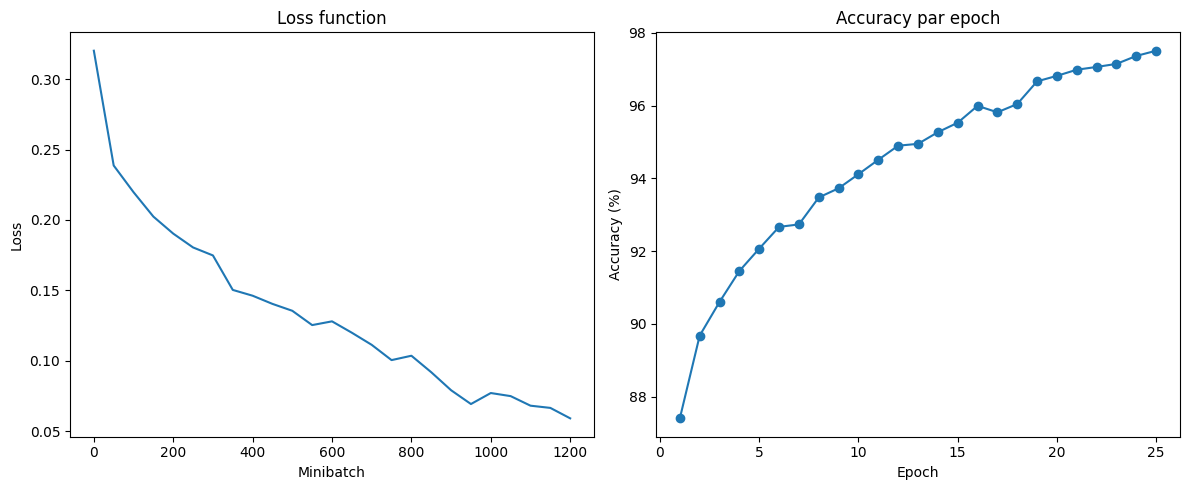

In [14]:
# Choix du modèle :
model = get_finetuned_resnet18()  # ou get_frozen_resnet18()

# Optimizer et loss
trainable_params = filter(lambda p: p.requires_grad, model.parameters()) # Choix des param en fonction du modele

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(trainable_params, lr=0.0005, betas=(0.9, 0.999))

# Entraînement
model.train()

loss_list = []
loss_list_idx = []
acc_list = []
compteur = 0

for epoch in range(25):
    running_loss = 0.0
    correct = 0
    total = 0
    start = time.time()

    model.train()  # Mode entraînement

    for i, (inputs, labels) in enumerate(train_loader):
        if i % 50 == 0:
            batch_start = time.time()

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Prédictions pour accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 50 == 49:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 50:.3f}')
            print(f"Batch {i} time: {time.time() - batch_start:.2f}s")
            loss_list.append(running_loss / 50)
            loss_list_idx.append(compteur * 50)
            running_loss = 0.0
            compteur += 1

    # Accuracy à la fin de l’époque
    epoch_acc = 100 * correct / total
    acc_list.append(epoch_acc)
    print(f'→ Accuracy après epoch {epoch + 1}: {epoch_acc:.2f}%')
    print(f"Epoch time: {time.time() - start:.2f}s")

print('Finished Training')

# Affichage des courbes
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_list_idx, loss_list)
plt.title("Loss function")
plt.xlabel("Minibatch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(range(1, len(acc_list) + 1), acc_list, marker='o')
plt.title("Accuracy par epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Accuracy on test set: 93.40%


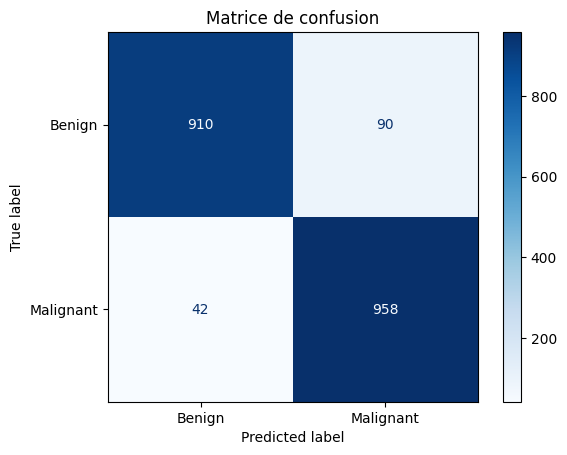

In [18]:
model.eval()

correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Accuracy globale
print(f'Accuracy on test set: {100 * correct / total:.2f}%')

# Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)

# Affichage
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion")
plt.show()